(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [32]:
# Load project package
@load_pkg Antibiotic

import Revise
# Import project package
import Antibiotic 

# Import package to save outputs
import BSON

# Import package to handle DataFrames
import DataFrames as DF
import CSV

# Import library to list files
import Glob

# Import packages to work with data
import DataFrames as DF

# Import statistical functions
import Random
import StatsBase

# Import basic math
import LinearAlgebra

# Import ML libraries
import Flux
import NNlib
import SimpleChains

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
Antibiotic.viz.pboc_makie!()

# Exploratory data analysis for Maeda et al., 2020 Nature Communications

In this notebook we will explore the resistance dataset from the [nature
communications](https://www.nature.com/articles/s41467-020-19713-w) paper by
Maeda et al.

First, we will explore the IC50 data. Let's load the tidy data frame.

In [2]:
# Define data directory
data_dir = "$(git_root())/data/Maeda_2020"

# Load file into memory
df_res = CSV.read("$(data_dir)/maeda_resistance_tidy.csv", DF.DataFrame)

last(df_res, 5)

Row,strain,stress,ic50,background,type,resistance
,String15,String15,Float64,String7,String7,String15
1,5.FOAE2,NMNO,-3.83195,MDS42,evolved,5.FOA
2,NMNOE5,NMNO,3.65591,MDS42,evolved,NMNO
3,NMNOE6,NMNO,4.91633,MDS42,evolved,NMNO
4,NMNOE1,NMNO,3.55628,MDS42,evolved,NMNO
5,NMNOE4,NMNO,3.2644,MDS42,evolved,NMNO


## SVD on resistance data

As a first pass through the data, let's perform singular value decomposition on
the resistance data. For this, we need to generate a matrix
$\underline{\underline{R}}$ with the resistance values, where each column
corresponds to one of the strains, and each row to each of the stresses.

In [19]:
# Initialize array to save data
IC50_mat = Matrix{Float32}(
    undef, length(unique(df_res.stress)), length(unique(df_res.strain))
)
# Group data by strain
df_group = DF.groupby(df_res, :strain)

# Extract unique stresses to make sure the matrix is built correctly
stress = sort(unique(df_res.stress))

# Loop through groups
for (i, data) in enumerate(df_group)
    # Sort data by stress
    DF.sort!(data, :stress)
    # Check that the stress are in the correct order
    if all(data.stress .== stress)
        # Add data to matrix
        IC50_mat[:, i] = Float32.(data.ic50)
    else
        println("group $i stress does not match")
    end # if
end # for

# Generate mean-centered matrix
IC50_center = IC50_mat .- StatsBase.mean(IC50_mat, dims=2);

Next, let's compute the singular value decomposition.

In [83]:
# Perform SVD on raw data
U, Σ, V = LinearAlgebra.svd(IC50_mat)

# Perform SVD on mean-centered data
U_center, Σ_center, V_center = LinearAlgebra.svd(IC50_center);

Let's look at the singular value profile.

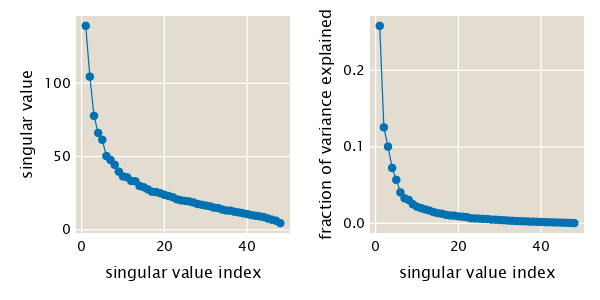

In [84]:
# Initialize figure
fig = Figure(resolution=(600, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="singular value index",
    ylabel="singular value",
    # yscale=log10,
)
ax2 = Axis(
    fig[1, 2],
    xlabel="singular value index",
    ylabel="fraction of variance explained",
    # yscale=log10,
)

# Plot singular value spectrum
scatterlines!(ax, Σ)
scatterlines!(ax2, Σ_center .^2 ./ sum(Σ_center .^2))

fig

## Training IRMAE on data

As an alternative to the SVD approach, let's instead attempt to train an
intrinsically rank minimizing autoencoder on this dataset. 

In [53]:
# Define number of epohcs
n_epoch = 10_000_000
# Define how often error should be computd
n_error = 10_000

# Define filename
fname = "$(git_root())/code/processing/irmae_maeda/output/$(n_epoch)_epoch/" *
        "irmae_20dimensions.bson"
# Load model
irmae = BSON.load(fname)[:irmae]
# Load mean squared error
mse = BSON.load(fname)[:mse_flux]
# Load standardized data
data_std = BSON.load(fname)[:data_std];

Before looking at the singular value spectrum, let's look at the mean squared
error as a function of epoch to make sure that the IRMAEs were properly trained.

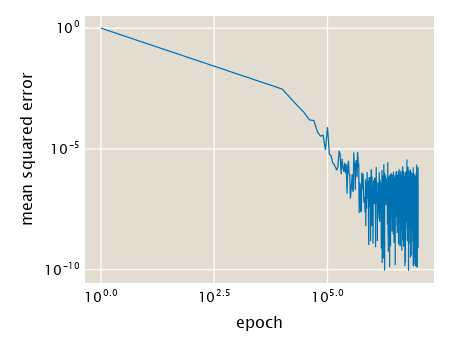

In [51]:
# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axes
ax = Axis(
    fig[1, 1],
    xlabel="epoch",
    ylabel="mean squared error",
    xscale=log10,
    yscale=log10,
)

# Plot error over time
lines!(
    ax, 
    [collect(1:n_error:n_epoch); [n_epoch]],
    mse
)

fig

This training curve look as expected. The longer the model is trained, the
lower the reconstruction mean squared error gets.

Let's compute the singular value decomposition of the latent-space
representation.

In [89]:
# Define number of hidden layers
n_hidden = 4
# Define number of linear layers
n_linear = 8
# Define location of latent-space layer
n_latent = n_hidden + n_linear + 1

# Map data into latent space
data_latent = Flux.activations(irmae, data_std)[n_latent]

# Generate mean-centered latent space data
data_latent_center = data_latent .- StatsBase.mean(data_latent, dims=2)

# Perform singular value decomposition
U_latent, Σ_latent, V_latent = LinearAlgebra.svd(data_latent)

# Perform singular value decomposition on mean-centered data
U_latent_center, Σ_latent_center, V_latent_center = LinearAlgebra.svd(
    data_latent_center
);

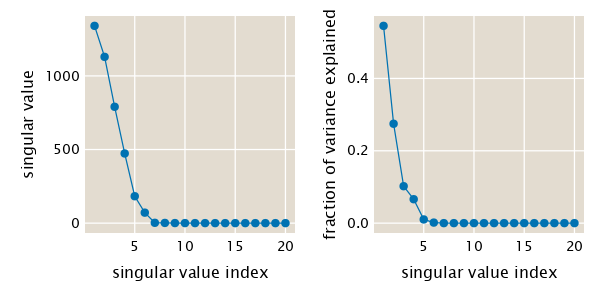

In [90]:
# Initialize figure
fig = Figure(resolution=(600, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="singular value index",
    ylabel="singular value",
    # yscale=log10,
)
ax2 = Axis(
    fig[1, 2],
    xlabel="singular value index",
    ylabel="fraction of variance explained",
    # yscale=log10,
)

# Plot singular value spectrum
scatterlines!(ax, Σ_latent)
scatterlines!(ax2, Σ_latent_center .^2 ./ sum(Σ_latent_center .^2))

fig

In [67]:
Flux.mse(irmae(data_std), data_std)

2.3567543f-8

In [76]:
# Compute SVD
U_std, Σ_std, V_std = LinearAlgebra.svd(data_std)
# Define index
idx = 20

# Truncate singular values
Σ_std_trunc = zeros(length(Σ_std))
Σ_std_trunc[1:idx] = Σ_std[1:idx]

Flux.mse(data_std, (U_std * LinearAlgebra.Diagonal(Σ_std_trunc) * V_std'))


0.15053925930938364